### Import dataset

In [1]:
# from google.colab import drive

# # Mount Google Drive
# drive.mount('/content/drive')

In [2]:
import pandas as pd
import numpy as np
# import category_encoders as ce
# import copy
# import polars as pl

# Visualization
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
import matplotlib
import seaborn as sns
# import plotly.express as px
# %matplotlib inline
# matplotlib.rcParams['font.family'] = 'Malgun Gothic' # 한글 패치
# Preprocessing & Feature Engineering
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.feature_selection import SelectPercentile
from sklearn.decomposition import PCA

# Hyperparameter Optimization
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Modeling
# from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.neural_network import MLPClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import ExtraTreesClassifier
# from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier, XGBRegressor, XGBRFRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier, VotingRegressor
from sklearn.ensemble import StackingClassifier, StackingRegressor
# from sklearn.base import ClassifierMixin

# CatBoost
# from catboost import CatBoostRegressor

# PyTorch
import torch
import torch.nn.init as init
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.nn import Parameter
from torch import Tensor
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Evaluation
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss,mean_squared_error
import sklearn

# Utility
import os
import time
import datetime # ⚠️2019년 12월30일과 31일의 week of year가 1인 오류가 있음
import random
import warnings; warnings.filterwarnings("ignore")
from IPython.display import Image
import pickle
from tqdm import tqdm
import platform
from itertools import combinations,product
from scipy.stats.mstats import gmean
import holidays

# from bayes_opt import BayesianOptimization
# from num2words import num2words
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import OLSInfluence

pd.set_option('display.max_row',None)
pd.set_option('display.max_column',None)

### Setting universal random_state
np.random.seed(142)
random.seed(142)
sklearn.utils.check_random_state(142)
torch.manual_seed(142)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.benchmark=False

try:
    import google.colab
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

# Make use of a GPU or MPS (Apple) if one is available.  (see module 3.2)
has_mps = torch.backends.mps.is_built()
device = "mps" if has_mps else "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Note: not using Google CoLab
Using device: cuda


### Merge dataset

In [3]:
class PrepareData():
    def __init__(self,stock_fp,news_fp):
        self.stock_filepath = stock_fp
        self.news_filepath = news_fp
        self.topic_classes = ['CEO', 'CFO', 'Layoffs', 'Political', 'PressRelease', 'Undefined',
       'cramer', 'earnings', 'gold', 'manda', 'paylimitwall', 'paywall',
       'product', 'recession', 'tanalysis'] # undefined의 class가 5

    def load_data(self):
        stock = pd.read_csv(self.stock_filepath,index_col=0)
        news = pd.read_csv(self.news_filepath,index_col=0)
        ### parse date manually
        stock['Date'] = pd.to_datetime(stock['Date'])
        news['date'] = pd.to_datetime(news['date'])
        return stock, news

    def merging(self, stock, news):
        ### fill na value of PINS column
#         stock['PINS'] = stock['PINS'].fillna(stock['PINS'].iloc[75])

        ### drop 'news_id' column
#         news = news.drop(columns=['news_id'])

        ### add date range from 18.01.02 to 18.12.31
        temp_range = pd.DataFrame(dict(zip(stock.columns,[pd.date_range(start='2018-01-02',end='2018-12-31'),
                                0,0,0,0, # 4
                                0,0,0,0,
                                0,0,0,0,
                                0,0,0,0, # 16
                                0,0,0,0,
                                0,0,0,0,
                                0,0,0,0, # 28
                                0,0,0,0,
                                0,0,0,0, # 36
                                0 # 37
                            ])))
        stock_inc = pd.concat([temp_range,stock],axis=0)

        ### merge stock_inc and news
        # left = stock_inc
        # on = date
        # how = left
        # rename 'date' to 'Date' of news df
        news = news.rename(columns={'date':'Date'})
        merged = pd.merge(left=stock_inc,right=news,on='Date',how='left')

        ### Cut before 2018-02-13
        merged = merged[42:].reset_index(drop=True)

        # fill na with latest non-null values
        columns_to_fill = ['source_name', 'topics', 'rank_score',
                        'sentiment_Negative','sentiment_Neutral',
                        'sentiment_Positive', 'type_Article', 'type_Video']
        merged_fillna = merged.copy()
        for column in columns_to_fill:
            merged_fillna[column].fillna(method='ffill',inplace=True)

        ### add moving average to sentiments
        ma_nums = [5,60,120]
        def mode_window(window):
            return window.mode().iloc[0] if not len(window.mode())==0 else None
        for num in ma_nums:
            merged_fillna[f'{num}MA_sent_Neg']=merged_fillna['sentiment_Negative'].rolling(
            window=num).mean()
            merged_fillna[f'{num}MA_sent_Neu']=merged_fillna['sentiment_Neutral'].rolling(
            window=num).mean()
            merged_fillna[f'{num}MA_sent_Pos']=merged_fillna['sentiment_Positive'].rolling(
            window=num).mean()
        ### add moving mode to sentiments
        for num in ma_nums:
            merged_fillna[f'{num}MM_sent_Neg']=merged_fillna['sentiment_Negative'].rolling(
            window=num).apply(mode_window)
            merged_fillna[f'{num}MM_sent_Neu']=merged_fillna['sentiment_Neutral'].rolling(
            window=num).apply(mode_window)
            merged_fillna[f'{num}MM_sent_Pos']=merged_fillna['sentiment_Positive'].rolling(
            window=num).apply(mode_window)
        ### adding moving mode to topics
        for num in ma_nums:
            merged_fillna[f'{num}MM_topics']=merged_fillna['topics'].rolling(
            window=num).apply(mode_window)

        ### drop before 2019-01-02
        total_df = merged_fillna.iloc[322:]
        total_df = total_df.reset_index(drop=True)

        ### drop unnecessaray columns
        drop_cols = ['source_name','topics','rank_score',
                    'sentiment_Negative','sentiment_Neutral',
                    'sentiment_Positive','type_Article','type_Video']
        total_df = total_df.drop(columns=drop_cols)

        return total_df

In [4]:
stock_filepath = '../../data/stock_price/netflix_60.csv' # 각자 파일 경로 설정
news_filepath = '../../data/scraping/news_processed_filtered_2.csv'
# stock_filepath = './drive/MyDrive/Colab Notebooks/data/bitamin_mini_project/netflix_60.csv'
# news_filepath = './drive/MyDrive/Colab Notebooks/data/bitamin_mini_project/news_processed_filtered_2.csv'
loader = PrepareData(stock_filepath, news_filepath)
stock_df, news_df=loader.load_data() # >> 감성분석 미포함으로 모델 돌릴 땐 stock_df 바로 사용하면 됨
total_df = loader.merging(stock=stock_df, news=news_df) # 주식데이터셋에 감성분석,토픽 포함시킨 전체 데이터셋
testfile = '../../data/test.csv'
test_df = pd.read_csv(testfile)

stock_df.index = stock_df["Date"]
stock_df.drop(columns = "Date", inplace = True)
stock_df["PINS"].fillna(24.99, inplace = True)
total_df.index = total_df["Date"]
total_df.drop(columns = "Date", inplace = True)
total_df["PINS"].fillna(24.99, inplace = True)

In [5]:
# pd.set_option('display.max_row',20)
# pd.set_option('display.max_column',8)
# total_df[['5MA_sent_Neg','5MA_sent_Neu','5MA_sent_Pos','60MA_sent_Neg',
#           '60MA_sent_Neu','60MA_sent_Pos','120MA_sent_Neg','120MA_sent_Neu',
#           '120MA_sent_Pos','5MM_sent_Neg','5MM_sent_Neu','5MM_sent_Pos',
#           '60MM_sent_Neg','60MM_sent_Neu','60MM_sent_Pos','120MM_sent_Neg',
#           '120MM_sent_Neu','120MM_sent_Pos','5MM_topics','60MM_topics',
#           '120MM_topics']].iloc[0:115]

In [6]:
 result_df = pd.DataFrame({
    'data':[0],
    'target':[0],
    'seq_size':[0],
    'pred_size':[0],
    'batch_size':[0],
    'hidden_size':[0],
    'best_val_loss':[0],
    'mean_error_ratio':[0]
})
result_df

,data,target,seq_size,pred_size,batch_size,hidden_size,best_val_loss,mean_error_ratio
0,0,0,0,0,0,0,0,0


In [7]:
best_losses = []
mean_error_ratios = []

datanames = ['total_df']#,'stock_df']

for dataname in datanames:
    ### Choose dataset & Hyperparameter setting
    if dataname=='total_df':
        data = total_df
    else:
        data = stock_df
    MODEL = 'Transformer'                 # 'LSTM' / 'GRU' / 'Transformer'
    TARGET = "1d_ROC"                      # "Close" / "1d_ROC"
    SEQ_SIZE = 120                         # 30 / 60 / 120
    PRED_SIZE = 10
    BATCH_SIZE = 1                        # 1 / 4 / 8
    HIDDEN_SIZE = 64                      # 64 / 128
    EPOCHS = 1000
    
    filename = f'{MODEL}_{dataname}_{TARGET}_seq{SEQ_SIZE}_batch{BATCH_SIZE}_hidden{HIDDEN_SIZE}'

    print(f'🔸START - {filename}🔸')
    ### Make train datset

    def split_xy(dataset, time_steps, y_column):
        x, y = list(), list()
        for i in range(len(dataset)):
            x_end_number = i + time_steps
            y_end_number = x_end_number + y_column

            if y_end_number > len(dataset):
                break
            tmp_x = dataset.iloc[i:x_end_number, :]  # Adjusted for Pandas
            tmp_y = dataset.iloc[x_end_number:y_end_number, :].loc[:, TARGET]
            x.append(tmp_x.values)  # Convert to numpy array
            y.append(tmp_y.values)  # Convert to numpy array

        return np.array(x), np.array(y)

    X, y = split_xy(data, SEQ_SIZE, PRED_SIZE)
#     print(X[0,:],"\n", y[0])
#     print("X size : ", X.shape)
#     print("y size : ", y.shape)

    ### Define X_test

    X_test = data.tail(SEQ_SIZE).values.reshape(1, SEQ_SIZE, data.shape[1])
#     print(X_test)
#     print("X_test size : ", X_test.shape)

    ### Standardization

    from sklearn.preprocessing import StandardScaler

    X = X.reshape(X.shape[0], X.shape[1] * X.shape[2])
    scaler = StandardScaler()
    scaler.fit(X)
    X = scaler.transform(X)
    X = X.reshape(X.shape[0], SEQ_SIZE, data.shape[1])

    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2])
    X_test = scaler.transform(X_test)
    X_test = X_test.reshape(X_test.shape[0], SEQ_SIZE, data.shape[1])

#     print("X size : ", X.shape)
#     print("X_test size : ", X_test.shape)

    ### Split train-validation dataset

    # to DataLoader
    import torch
    from torch.utils.data import Dataset, DataLoader, TensorDataset
    from sklearn.model_selection import train_test_split

    for trial in tqdm(list(range(1,11))):
        X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state = 1, test_size = 0.2)

        # to tensor
        X_train = torch.tensor(X_train.astype(np.float32), dtype = torch.float32)
        X_valid = torch.tensor(X_valid.astype(np.float32), dtype = torch.float32)
        y_train = torch.tensor(y_train.astype(np.float32), dtype = torch.float32)
        y_valid = torch.tensor(y_valid.astype(np.float32), dtype = torch.float32)

        # to DataLoader
        train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size = BATCH_SIZE, shuffle = True)
        val_loader = DataLoader(TensorDataset(X_valid, y_valid), batch_size = BATCH_SIZE, shuffle = False)

        ### Initialize Model
        try:
            for param in model.parameters():
                if param.requires_grad:
                    if len(param.shape) > 1:
                        init.xavier_uniform_(param)
                    else:
                        init.zeros_(param)
        except:
            try:
                model.reset_parameters()
            except:
                pass

        ### Modeling

        import copy
        class EarlyStopping:
            def __init__(self, patience = 5, min_delta = 0, restore_best_weights = True):
                self.patience = patience
                self.min_delta = min_delta
                self.restore_best_weights = restore_best_weights
                self.best_model = None
                self.best_loss = None
                self.counter = 0
                self.status = ""

            def __call__(self, model, val_loss):
                if self.best_loss is None:
                    self.best_loss = val_loss
                    self.best_model = copy.deepcopy(model.state_dict())
                elif self.best_loss - val_loss >= self.min_delta:
                    self.best_model = copy.deepcopy(model.state_dict())
                    self.best_loss = val_loss
                    self.counter = 0
                    self.status = f"Improvement found, counter reset to {self.counter}"
                else:
                    self.counter += 1
                    self.status = f"No improvement in the last {self.counter} epochs"
                    if self.counter >= self.patience:
                        self.status = f"Early stopping triggered after {self.counter} epochs."
                        if self.restore_best_weights:
                            model.load_state_dict(self.best_model)
                        return True
                return False

        # Positional Encoding for Transformer
        class PositionalEncoding(nn.Module):
            def __init__(self, d_model, dropout=0.1, max_len=1000):
                super(PositionalEncoding, self).__init__()
                self.dropout = nn.Dropout(p=dropout)

                pe = torch.zeros(max_len, d_model)
                position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
                div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
                pe[:, 0::2] = torch.sin(position * div_term)
                pe[:, 1::2] = torch.cos(position * div_term)
                pe = pe.unsqueeze(0).transpose(0, 1)
                self.register_buffer('pe', pe)

            def forward(self, x):
                x = x + self.pe[:x.size(0), :]
                return self.dropout(x)

        # Model definition using Transformer
        class TransformerModel(nn.Module):
            def __init__(self, input_dim, d_model, nhead=4, num_layers=2, dropout=0.2, output_size=10):
                super(TransformerModel, self).__init__()

                self.encoder = nn.Linear(input_dim, d_model,bias=True)
                self.pos_encoder = PositionalEncoding(d_model, dropout)
                encoder_layers = nn.TransformerEncoderLayer(d_model, nhead,bias=True)
                self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
                self.decoder = nn.Linear(d_model, output_size,bias=True)

            def forward(self, x):
                x = self.encoder(x)
                x = self.pos_encoder(x)
                x = self.transformer_encoder(x)
                x = self.decoder(x[:, -1, :])
                return x

        class RMSELoss(nn.Module):
            def __init__(self):
                super(RMSELoss,self).__init__()
                self.mse = nn.MSELoss()

            def forward(self,yhat,y):
                return torch.sqrt(self.mse(yhat,y))

        model = TransformerModel(X_train.shape[2],
                                d_model = HIDDEN_SIZE,
                                output_size = PRED_SIZE).to(device)
        criterion = RMSELoss()
        optimizer = optim.Adam(model.parameters(), lr = 0.001)
        scheduler = ReduceLROnPlateau(optimizer, 'min', factor = 0.1, patience = 20, verbose = True)

        ### RUN!!

        epoch_counter = 0
        patience = 30
        best_loss = float('inf')
        done = False
        es = EarlyStopping(patience=patience)
        tr_losses_fp, val_losses_fp = [],[]

        while not done and epoch_counter<EPOCHS:
            epoch_counter+=1

            # train
            model.train()
            train_losses = []
            for batch in train_loader:
                x_batch, y_batch = batch
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                optimizer.zero_grad()
                output = model(x_batch)
                loss = criterion(output,y_batch)
                loss.backward()
                optimizer.step()
                train_losses.append(loss.item())
            train_loss = np.mean(train_losses)
            tr_losses_fp.append(train_loss)

            # validation
            model.eval()
            val_losses = []
            with torch.no_grad():
                for batch in val_loader:
                    x_batch, y_batch = batch
                    x_batch = x_batch.to(device)
                    y_batch = y_batch.to(device)
                    output = model(x_batch)
                    loss = criterion(output, y_batch)
                    val_losses.append(loss.item())
            val_loss = np.mean(val_losses)
            val_losses_fp.append(val_loss)
            scheduler.step(val_loss)

            if es(model, val_loss):
                done = True

            if val_loss < best_loss:
                best_loss = val_loss

            if epoch_counter%20 == 0:
                print(f"Epoch {epoch_counter}/{EPOCHS}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

        print(f"Best validation loss : {best_loss}")
        best_losses.append(best_loss)
        
        ### Visualize train-validation loss

#         plt.plot(range(len(tr_losses_fp)),tr_losses_fp,color='blue',label='train_loss')
#         plt.plot(range(len(val_losses_fp)),val_losses_fp,color='red',label='val_loss')
#         plt.legend()
#         # plt.show()
#         plt.savefig(f'../../plots/train_val_loss_2/{filename}.png')
#         plt.clf()
        globals()[f'train_losses_{trial}']=tr_losses_fp
        globals()[f'val_losses_{trial}']=val_losses_fp

        ### Prediction

        # evaluation
        model.eval()
        with torch.no_grad():
            X_test_tensor = torch.tensor(X_test.astype(np.float32), dtype = torch.float32,device=device)
            pred = model(X_test_tensor)

        pred = pred.to('cpu').detach().numpy()
        # print(pred)

        if TARGET == "1d_ROC" :
            endPrice = data['Close'].iloc[-1]
            pred_close = []

            for i in pred[0] :
                endPrice = endPrice + endPrice*0.01*i
                pred_close.append(endPrice)

            pred = np.array(pred_close).reshape(1, PRED_SIZE)
        #     pred
        else :
            pass

        globals()[f'pred_{trial}'] = pred
        
        # pred_length = len(np.reshape(pred, (-1)))
        # pred_indices = list(range(pred_length))
        # plt.plot(pred_indices, np.reshape(pred, (-1)), color='red', alpha=0.6, label='Prediction')
        # plt.legend()

        # plt.show()

        ### Evaluation

        # Label
#         testfile = '../../data/test.csv'
#         test_df = pd.read_csv(testfile)
#         label = pd.read_csv(testfile) # 각자 test.csv 파일 경로
        label = test_df.copy()
        label = np.array(label.head(PRED_SIZE)["Close Price"])

        # Prediction
        pred = np.array(pred).reshape(PRED_SIZE)

        # 날짜 데이터
        period = test_df["Date"].copy()
        period = [d for d in period.head(PRED_SIZE)]

        # 오차율 계산
        error_rate = np.abs((label - pred) / label) * 100

        # 시각화
#         plt.figure(figsize=(12, 6))
#         plt.plot(period, label, marker='o', color='blue', label='Actual Close Price')
#         plt.plot(period, pred, marker='x', color='red', linestyle='--', label='Predicted Close Price')

#         # 오차율을 각 포인트에 텍스트로 표시
#         for date, lbl, prd, err in zip(period, label, pred, error_rate):
#             plt.text(date, prd, f'{err:.2f}%', color='black', ha='right', va='bottom')

#         plt.xticks(rotation = 45)  # 날짜 레이블 회전
#         plt.xlabel('Date')
#         plt.ylabel('Close Price')
#         plt.title(f'model = LSTM, data = {dataname}, target = {TARGET}, seq_size = {SEQ_SIZE}, pred_size = {PRED_SIZE}, batch_size = {BATCH_SIZE}, model_size = {HIDDEN_SIZE}')
#         plt.legend()
#         plt.tight_layout()  # 레이아웃 조정
#         # plt.show()
#         plt.savefig(f'../../plots/results_2/{filename}.png')
#         plt.clf()

        # 오차율을 출력
        error_rate_dict = dict(zip(period, error_rate))
        # error_rate_dict

        # 평균 오차율 계산
        average_error_rate = np.mean(error_rate)
        
        print(f"Average Error Rate: {average_error_rate:.2f}%")
        mean_error_ratios.append(average_error_rate)
        
        ### Save results to a DataFrame
#         temp_df = pd.DataFrame({
#             'data':[dataname],
#             'target':[TARGET],
#             'seq_size':[SEQ_SIZE],
#             'pred_size':[PRED_SIZE],
#             'batch_size':[BATCH_SIZE],
#             'hidden_size':[HIDDEN_SIZE],
#             'best_val_loss':[best_loss],
#             'mean_error_ratio':[average_error_rate]
#         })

#         result_df = pd.concat([result_df,temp_df],axis=0)
print('🔸END🔸')

🔸START - Transformer_total_df_1d_ROC_seq120_batch1_hidden64🔸


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Epoch 20/1000, Train Loss: 2.5475, Validation Loss: 2.5066
Epoch 40/1000, Train Loss: 2.5249, Validation Loss: 2.4814
Epoch 60/1000, Train Loss: 2.5210, Validation Loss: 2.4798
Epoch 80/1000, Train Loss: 2.5130, Validation Loss: 2.4782
Epoch 100/1000, Train Loss: 2.5091, Validation Loss: 2.4755
Epoch 00109: reducing learning rate of group 0 to 1.0000e-04.
Epoch 120/1000, Train Loss: 2.4961, Validation Loss: 2.4672
Epoch 00136: reducing learning rate of group 0 to 1.0000e-05.
Epoch 140/1000, Train Loss: 2.4942, Validation Loss: 2.4682


 10%|███████▉                                                                       | 1/10 [30:55<4:38:15, 1855.03s/it]

Best validation loss : 2.466090818685768
Average Error Rate: 2.03%
Epoch 20/1000, Train Loss: 2.5306, Validation Loss: 2.4818
Epoch 40/1000, Train Loss: 2.5184, Validation Loss: 2.4793
Epoch 60/1000, Train Loss: 2.5117, Validation Loss: 2.4729
Epoch 00075: reducing learning rate of group 0 to 1.0000e-04.
Epoch 80/1000, Train Loss: 2.4944, Validation Loss: 2.4652
Epoch 00096: reducing learning rate of group 0 to 1.0000e-05.
Epoch 100/1000, Train Loss: 2.4904, Validation Loss: 2.4668


 20%|███████████████▊                                                               | 2/10 [53:30<3:28:08, 1561.05s/it]

Best validation loss : 2.4640632925835333
Average Error Rate: 1.92%
Epoch 20/1000, Train Loss: 2.5331, Validation Loss: 2.4816
Epoch 40/1000, Train Loss: 2.5232, Validation Loss: 2.4976
Epoch 00043: reducing learning rate of group 0 to 1.0000e-04.


 30%|███████████████████████                                                      | 3/10 [1:04:21<2:13:38, 1145.56s/it]

Best validation loss : 2.4801408724974743
Average Error Rate: 1.92%
Epoch 20/1000, Train Loss: 2.5334, Validation Loss: 2.4922
Epoch 40/1000, Train Loss: 2.5145, Validation Loss: 2.5032
Epoch 00060: reducing learning rate of group 0 to 1.0000e-04.
Epoch 60/1000, Train Loss: 2.5093, Validation Loss: 2.4736
Epoch 80/1000, Train Loss: 2.4944, Validation Loss: 2.4734
Epoch 00093: reducing learning rate of group 0 to 1.0000e-05.
Epoch 100/1000, Train Loss: 2.4907, Validation Loss: 2.4737


 40%|██████████████████████████████▊                                              | 4/10 [1:25:53<2:00:19, 1203.31s/it]

Best validation loss : 2.470663995869392
Average Error Rate: 2.00%
Epoch 20/1000, Train Loss: 2.5371, Validation Loss: 2.4960
Epoch 40/1000, Train Loss: 2.5216, Validation Loss: 2.4843
Epoch 60/1000, Train Loss: 2.5167, Validation Loss: 2.5096
Epoch 80/1000, Train Loss: 2.5068, Validation Loss: 2.4821
Epoch 100/1000, Train Loss: 2.4999, Validation Loss: 2.4763
Epoch 00108: reducing learning rate of group 0 to 1.0000e-04.
Epoch 120/1000, Train Loss: 2.4863, Validation Loss: 2.4777
Epoch 00129: reducing learning rate of group 0 to 1.0000e-05.


 50%|██████████████████████████████████████▌                                      | 5/10 [1:54:44<1:56:08, 1393.69s/it]

Best validation loss : 2.4697323523264014
Average Error Rate: 2.79%
Epoch 20/1000, Train Loss: 2.5436, Validation Loss: 2.4954
Epoch 40/1000, Train Loss: 2.5299, Validation Loss: 2.4878
Epoch 60/1000, Train Loss: 2.5122, Validation Loss: 2.4758
Epoch 80/1000, Train Loss: 2.5085, Validation Loss: 2.4682
Epoch 100/1000, Train Loss: 2.5011, Validation Loss: 2.4725
Epoch 00105: reducing learning rate of group 0 to 1.0000e-04.


 60%|██████████████████████████████████████████████▏                              | 6/10 [2:13:12<1:26:25, 1296.49s/it]

Best validation loss : 2.4679099738070396
Average Error Rate: 1.78%
Epoch 20/1000, Train Loss: 2.5386, Validation Loss: 2.4896
Epoch 40/1000, Train Loss: 2.5257, Validation Loss: 2.4816
Epoch 60/1000, Train Loss: 2.5197, Validation Loss: 2.4892
Epoch 80/1000, Train Loss: 2.5133, Validation Loss: 2.4866
Epoch 100/1000, Train Loss: 2.5022, Validation Loss: 2.4779
Epoch 120/1000, Train Loss: 2.5104, Validation Loss: 2.4831
Epoch 00129: reducing learning rate of group 0 to 1.0000e-04.


 70%|█████████████████████████████████████████████████████▉                       | 7/10 [2:40:24<1:10:18, 1406.23s/it]

Best validation loss : 2.463411228582922
Average Error Rate: 3.07%
Epoch 20/1000, Train Loss: 2.5293, Validation Loss: 2.4835
Epoch 40/1000, Train Loss: 2.5141, Validation Loss: 2.4741
Epoch 60/1000, Train Loss: 2.5022, Validation Loss: 2.4626
Epoch 80/1000, Train Loss: 2.5022, Validation Loss: 2.4694
Epoch 00085: reducing learning rate of group 0 to 1.0000e-04.


 80%|███████████████████████████████████████████████████████████████▏               | 8/10 [2:57:31<42:51, 1285.63s/it]

Best validation loss : 2.460884265403832
Average Error Rate: 1.83%
Epoch 20/1000, Train Loss: 2.5376, Validation Loss: 2.4887
Epoch 40/1000, Train Loss: 2.5185, Validation Loss: 2.4804
Epoch 60/1000, Train Loss: 2.5169, Validation Loss: 2.4803
Epoch 80/1000, Train Loss: 2.5048, Validation Loss: 2.4752
Epoch 00090: reducing learning rate of group 0 to 1.0000e-04.


 90%|███████████████████████████████████████████████████████████████████████        | 9/10 [3:18:25<21:15, 1275.56s/it]

Best validation loss : 2.4680029694485452
Average Error Rate: 2.16%
Epoch 20/1000, Train Loss: 2.5257, Validation Loss: 2.4855
Epoch 40/1000, Train Loss: 2.5144, Validation Loss: 2.4719
Epoch 60/1000, Train Loss: 2.5029, Validation Loss: 2.4689
Epoch 00068: reducing learning rate of group 0 to 1.0000e-04.
Epoch 80/1000, Train Loss: 2.4856, Validation Loss: 2.4657
Epoch 100/1000, Train Loss: 2.4856, Validation Loss: 2.4697
Epoch 00101: reducing learning rate of group 0 to 1.0000e-05.


100%|██████████████████████████████████████████████████████████████████████████████| 10/10 [3:42:17<00:00, 1333.80s/it]

Best validation loss : 2.4657261980845866
Average Error Rate: 1.73%
🔸END🔸


In [8]:
preds = []
for t in list(range(1,11)):
    preds.append(globals()[f'pred_{t}'].tolist())
preds = np.reshape(np.array(preds),(10,10))
preds

array([[485.16826346, 483.95533991, 482.75997032, 481.50180115,
        480.09589153, 479.45716704, 478.13238282, 476.1657542 ,
        473.88965685, 471.61572744],
       [487.03523453, 486.98851887, 486.76158437, 486.74586235,
        486.67692649, 486.71465082, 486.41800782, 486.01692698,
        485.85224776, 485.77910093],
       [487.06021999, 487.07493763, 487.01092744, 486.67868479,
        486.53130638, 486.57167584, 486.1267104 , 485.69663252,
        485.64679382, 485.68476789],
       [487.18235524, 487.44593352, 487.48487004, 487.38784426,
        487.39883616, 487.55243124, 487.46703224, 487.10564272,
        486.92680418, 487.06457074],
       [485.19777987, 483.11349817, 480.77048403, 477.93621961,
        475.38456133, 473.06189094, 470.32831585, 467.60955827,
        465.49958879, 463.99352584],
       [486.52849556, 486.14471516, 485.80839269, 485.76215957,
        485.22664911, 484.93871085, 484.58792412, 483.74371709,
        483.18227117, 482.58212026],
       [48

In [9]:
preds_df = pd.DataFrame(preds,columns=['model_1','model_2',
                           'model_3','model_4',
                           'model_5','model_6',
                           'model_7','model_8',
                           'model_9','model_10'])
preds_df['Mean']=preds_df.mean(axis=1)
preds_df

,model_1,model_2,model_3,model_4,model_5,model_6,model_7,model_8,model_9,model_10,Mean
0,485.168263,483.955340,482.759970,481.501801,480.095892,479.457167,478.132383,476.165754,473.889657,471.615727,479.274195
1,487.035235,486.988519,486.761584,486.745862,486.676926,486.714651,486.418008,486.016927,485.852248,485.779101,486.498906
2,487.060220,487.074938,487.010927,486.678685,486.531306,486.571676,486.126710,485.696633,485.646794,485.684768,486.408266
3,487.182355,487.445934,487.484870,487.387844,487.398836,487.552431,487.467032,487.105643,486.926804,487.064571,487.301632
4,485.197780,483.113498,480.770484,477.936220,475.384561,473.061891,470.328316,467.609558,465.499589,463.993526,474.289542
5,486.528496,486.144715,485.808393,485.762160,485.226649,484.938711,484.587924,483.743717,483.182271,482.582120,484.850516
6,488.003538,489.265041,490.647826,491.964331,493.974013,495.782605,497.308508,498.386027,499.350707,500.520753,494.520335
7,486.737013,486.708725,486.184273,485.945398,485.574949,485.400475,485.088436,484.607060,484.732378,484.836282,485.581499
8,487.551842,488.287164,488.453038,488.877678,489.535274,489.868928,490.104820,490.094080,490.058343,489.744080,489.257525
9,486.097176,485.490523,484.613386,483.736778,483.132530,482.641341,481.983375,481.032324,480.448442,480.163249,482.933912


In [10]:
results_df = pd.DataFrame([best_losses,mean_error_ratios], columns=[
                            'model_1','model_2',
                           'model_3','model_4',
                           'model_5','model_6',
                           'model_7','model_8',
                           'model_9','model_10'])
print('Mean Val_Loss :',results_df.iloc[0].mean())
print('Mean Error Ratio :',results_df.iloc[1].mean())
results_df

Mean Val_Loss : 2.467662596728949
Mean Error Ratio : 2.1242340349853976


,model_1,model_2,model_3,model_4,model_5,model_6,model_7,model_8,model_9,model_10
0,2.466091,2.464063,2.480141,2.470664,2.469732,2.467910,2.463411,2.460884,2.468003,2.465726
1,2.032468,1.921377,1.924247,1.999977,2.793700,1.780786,3.071736,1.834043,2.156159,1.727847


In [11]:
d5_period = ['2023-12-22','2023-12-26','2023-12-27','2023-12-28','2023-12-29']
stock_df.loc[d5_period,'Close'].to_numpy()

array([486.76, 491.19, 491.79, 490.51, 486.88])

In [12]:
d5_stock = stock_df.loc[d5_period,'Close'].to_list()
d5_stock + label.tolist()

[486.76,
 491.19,
 491.79,
 490.51,
 486.88,
 468.5,
 470.26,
 474.67,
 474.06,
 485.03,
 482.09,
 478.33,
 492.23,
 492.16,
 481.24]

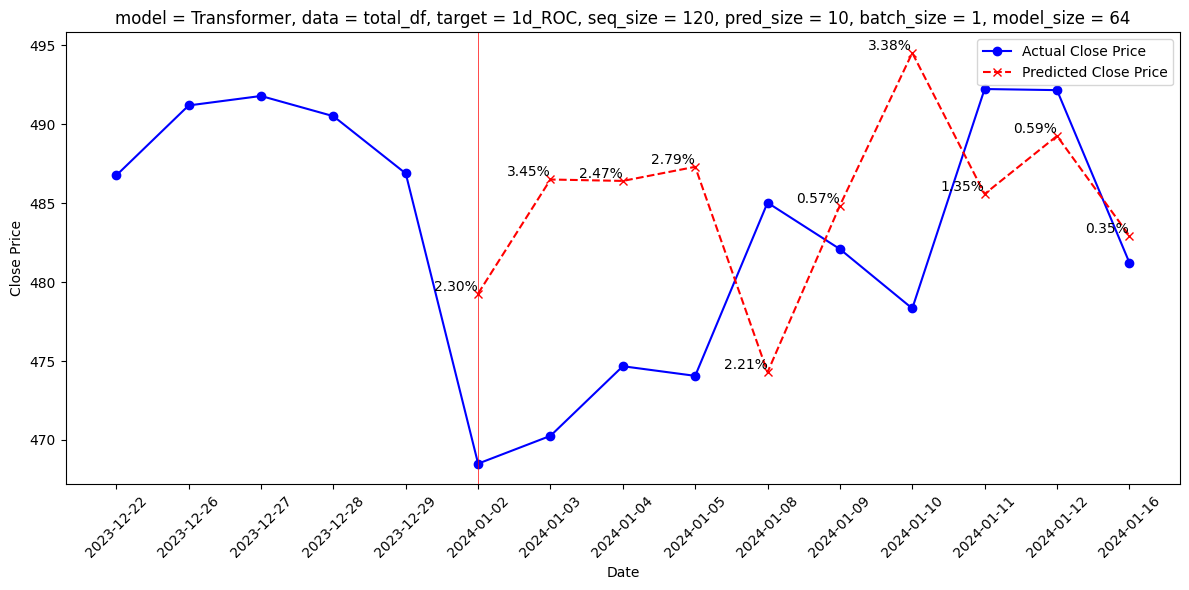

Average Error Rate: 1.95%


<Figure size 640x480 with 0 Axes>

In [13]:
# 시각화
label = test_df.copy()
label = np.array(label.head(PRED_SIZE)["Close Price"])

# Prediction
pred_ = preds_df['Mean'].to_numpy().reshape(PRED_SIZE)

# 날짜 데이터
period = test_df["Date"].copy()
period = [d for d in period.head(PRED_SIZE)]
d5_period = ['2023-12-22','2023-12-26','2023-12-27','2023-12-28','2023-12-29']
d5_stock = stock_df.loc[d5_period,'Close'].to_list()

# 오차율 계산
error_rate = np.abs((label - pred_) / label) * 100

plt.figure(figsize=(12, 6))
plt.plot(d5_period+period, d5_stock+label.tolist(), marker='o', color='blue', label='Actual Close Price')
plt.plot(period, pred_, marker='x', color='red', linestyle='--', label='Predicted Close Price')
plt.axvline(x='2024-01-02', color='red',linestyle='-',linewidth=.5)
# 오차율을 각 포인트에 텍스트로 표시
for date, lbl, prd, err in zip(period, label, pred_, error_rate):
    plt.text(date, prd, f'{err:.2f}%', color='black', ha='right', va='bottom')

    
plt.xticks(rotation = 45)  # 날짜 레이블 회전
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title(f'model = {MODEL}, data = {dataname}, target = {TARGET}, seq_size = {SEQ_SIZE}, pred_size = {PRED_SIZE}, batch_size = {BATCH_SIZE}, model_size = {HIDDEN_SIZE}')
plt.legend()
plt.tight_layout()  # 레이아웃 조정
plt.savefig(f'../../plots/best_plots/10trials_{filename}.png') #### 본인 파일 경로
plt.show()
plt.clf()

# 오차율을 출력
error_rate_dict = dict(zip(period, error_rate))
# error_rate_dict

# 평균 오차율 계산
average_error_rate = np.mean(error_rate)

print(f"Average Error Rate: {average_error_rate:.2f}%")
mean_error_ratios.append(average_error_rate)

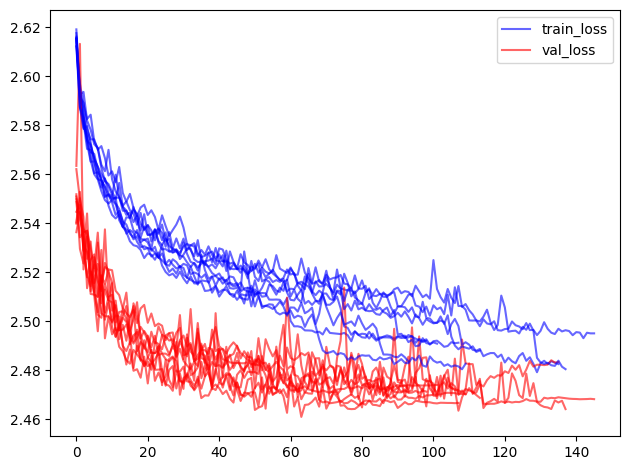

<Figure size 640x480 with 0 Axes>

In [14]:
### Visualize train-validation loss

for t in list(range(1,11)):
    plt.plot(range(len(globals()[f'train_losses_{t}'])),
             globals()[f'train_losses_{t}'],
             color='blue',alpha=0.6)
    plt.plot(range(len(globals()[f'val_losses_{t}'])),
             globals()[f'val_losses_{t}'],
             color='red',alpha=0.6)
plt.legend(['train_loss','val_loss'])
plt.tight_layout()
plt.savefig(f'../../plots/best_plots/10trials_train_val_loss_{filename}.png')
plt.show()
plt.clf()